In [3]:
# referenced https://srush.github.io/annotated-s4/#part-1b-addressing-long-range-dependencies-with-hippo

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from utils import init_random_seeds
from model._utils import SSM, CTRNN

# Initialize the random seeds
init_random_seeds(42)


Input signal: (torch.Size([2, 1000, 8]), torch.float32)
Target signal: (torch.Size([2, 1000]), torch.float32)
Output signal: (torch.Size([2, 1000]), torch.float32)



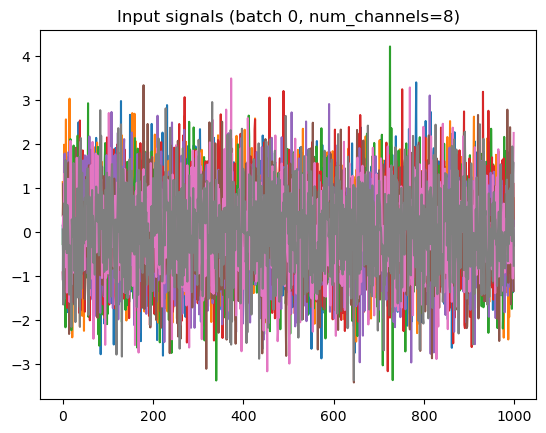

Epoch: 0 	 Loss: 0.573171854019165

step gradient: 0.4150879979133606
A.weight gradient: None
B.weight gradient: 0.3266189396381378

Epoch: 1 	 Loss: 0.5257745981216431
Epoch: 2 	 Loss: 0.4771046042442322
Epoch: 3 	 Loss: 0.42816728353500366
Epoch: 4 	 Loss: 0.3820887506008148
Epoch: 5 	 Loss: 0.3434522747993469
Epoch: 6 	 Loss: 0.3165897727012634
Epoch: 7 	 Loss: 0.30109772086143494
Epoch: 8 	 Loss: 0.29076072573661804
Epoch: 9 	 Loss: 0.2793200612068176
Epoch: 10 	 Loss: 0.2651505768299103


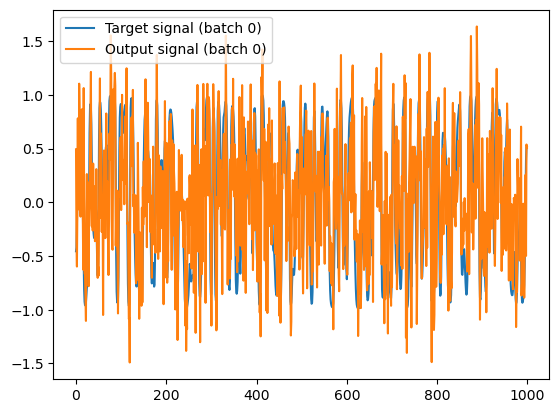

CPU times: user 25.2 s, sys: 172 ms, total: 25.4 s
Wall time: 7.09 s


In [4]:
%%time

model_dim = 50
timesteps = 1000
num_channels = 8
batch_size = 2
epochs = 10

model = SSM(input_size=num_channels, hidden_size=model_dim)
# model = CTRNN(input_size=num_channels, hidden_size=model_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

input_signal = torch.randn((batch_size, timesteps, num_channels))
print(f"Input signal: {input_signal.shape, input_signal.dtype}")

kernel = signal.windows.gaussian(15, 2)
kernel = kernel / kernel.sum()
# Target signal is the sum of the convolutions of the input signals with the Gaussian kernel -- something quite complicated and nonlinear
target_signal = (
    torch.from_numpy(
        np.stack(
            [
                np.stack(
                    [
                        signal.fftconvolve(input_signal[b, :, c].numpy(), kernel, mode="same")
                        for c in range(num_channels)
                    ],
                    axis=-1,
                )
                for b in range(batch_size)
            ],
            axis=0,
        )
    )
    .to(dtype=input_signal.dtype)
    .sum(dim=-1)
    .tanh()
)
print(f"Target signal: {target_signal.shape, target_signal.dtype}")

output_signal, hidden_state = model(input_signal)
output_signal = output_signal.sum(dim=-1)
print(f"Output signal: {output_signal.shape, output_signal.dtype}\n")

plt.plot(input_signal[0, :, :].numpy())
plt.title("Input signals (batch 0, num_channels=8)")
plt.show()

optimizer.zero_grad()
loss = criterion(output_signal, target_signal)
print(f"Epoch: 0 \t Loss: {loss.item()}")
loss.backward()
optimizer.step()

print()
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient: {param.grad.norm().item()}")
    else:
        print(f"{name} gradient: None")
print()

for i in range(epochs):
    output_signal, hidden_state = model(input_signal)
    output_signal = output_signal.sum(dim=-1)

    optimizer.zero_grad()
    loss = criterion(output_signal, target_signal)
    print(f"Epoch: {i+1} \t Loss: {loss.item()}")
    loss.backward()
    optimizer.step()

plt.plot(target_signal[0, :].numpy(), label="Target signal (batch 0)")
plt.plot(output_signal[0, :].detach().numpy(), label="Output signal (batch 0)")
plt.legend()
plt.show()

#### Speed on `seq_len=500`

`K_conv`
Epoch: 0 	 Loss: 0.553228497505188

Epoch: 10 	 Loss: 0.22177010774612427

CPU times: user 26.8 s, sys: 290 ms, total: 27.1 s

Wall time: 9.59 s

---

`K_conv_fast`

Epoch: 0 	 Loss: 0.48821836709976196

Epoch: 10 	 Loss: 0.2428039312362671

CPU times: user 25.6 s, sys: 139 ms, total: 25.7 s

Wall time: 8.7 s

---